# Machine Learning Approaches to Ethical Analysis of Statistics (ICS5110)

Aim and Objectives:
* Transform and analyse raw, tabular daily_temp_tsdf from a statistics website.
* Apply multiple machine-learning techniques to this daily_temp_tsdf.
* Investigate and document ethical and social implications.
* Create a data project and analysis related to real-life statistics.
* Deadline: 10th January 2024

Deliverables:
* 20 Pages (Maximum) Document in the IEEE Access format
* Project GitHub Pages Webpage
* 10 Page (Maximum) Generative AI Usage Journal

**IMPORTANT**: For dependencies, running and committing this notebooks, see: [README](./README.md)

## Problem: Given the Climate and Population Trends, Can we forcecast Electricity Demands?

Model Outcomes:
* Energy Demand Forecasting
* Risk - Outages, Climate, etc?

# Data Preparation & Wrangling

### Provenance
Electricity:
- [NSO Excel: Electricity supply by year](https://nso.gov.mt/electricity-supply-2022/?fbclid=IwAR3ZCJBJjgVKAS6MyXQR__Rhg3zEaJQXsG1Nz-1IYWDCtezH3N26rIdL3ZA)
- [NSO Excel: Gross production of electricity by month and year](https://nso.gov.mt/electricity-supply-2022/?fbclid=IwAR3ZCJBJjgVKAS6MyXQR__Rhg3zEaJQXsG1Nz-1IYWDCtezH3N26rIdL3ZA)
- [NSO Excel: Electricity production from power plants by month and year](https://nso.gov.mt/electricity-supply-2022/?fbclid=IwAR3ZCJBJjgVKAS6MyXQR__Rhg3zEaJQXsG1Nz-1IYWDCtezH3N26rIdL3ZA)
- [NSO Excel: Estimated electricity production from renewable sources by month and year](https://nso.gov.mt/electricity-supply-2022/?fbclid=IwAR3ZCJBJjgVKAS6MyXQR__Rhg3zEaJQXsG1Nz-1IYWDCtezH3N26rIdL3ZA)
- [NSO Excel: Imports and exports of electricity by month and year](https://nso.gov.mt/electricity-supply-2022/?fbclid=IwAR3ZCJBJjgVKAS6MyXQR__Rhg3zEaJQXsG1Nz-1IYWDCtezH3N26rIdL3ZA)
- [NSO Excel: Electricity supply by month and year](https://nso.gov.mt/electricity-supply-2022/?fbclid=IwAR3ZCJBJjgVKAS6MyXQR__Rhg3zEaJQXsG1Nz-1IYWDCtezH3N26rIdL3ZA)
- [Malta Resources Authority tableau: GHG emissions by year](https://public.tableau.com/app/profile/maltaresourcesauthority/viz/test_16911097613970/BySector)
- [Eurostat CSV: Net electricity generation by type of fuel - monthly data](https://ec.europa.eu/eurostat/databrowser/view/nrg_cb_pem__custom_8232363/default/table?lang=en)

Climate:
- [Meteostat: Temperature](https://dev.meteostat.net/sources.html)

Population:
- [Worldbank CSV: Population](https://data.worldbank.org/country/malta)

Indutrial Indices:
- [Worldbank CSV: GDP in Local Currency Unit (Euro)](https://data.worldbank.org/indicator/NY.GDP.MKTP.CN.AD?locations=MT&view=chart)

### Processing

* **Manual** edit of CSV to delete text, disclaimers and images from NSO. Output is a clean table.
* Removal of **features with >20% NaNs**. Too many gaps to interpolate.
* Drop data **> 3 standard deviations**.
* Resample to 22years from **2000 to 2022**.
* Normalize and reduce data. E.g. Mega Watts to Giga Watts, Minutes to Days, etc.
* Linear **interpolation of NaNs**.

In [1]:
import os
import re

import numpy as np
import pandas as pd
from datetime import datetime
from scipy.stats import skew, kurtosis

import matplotlib.pyplot as plt

## Power Timeseries

These timeseries have been scraped from the NSO publications. The data-quality is moderate, requiring resampling, inputting of missing datapoints, and scaling to the giga scale.

In [2]:
# Constants here
START_DATE = datetime(2003, 1, 1)
END_DATE = datetime(2022, 12, 31)

# All unprocessed CVs should go here.
RAW_DATA_PATH = "./raw_data"

# Base electricity datasets
ELEC_DMD_COL = "Max_Demand_GW"
ELEC_PROD_COL = "Plant_Production_GWh"
ELECTRIC_MW_DS = [
    "Max_Demand_MW.csv",
    "Plant_Production_MWh.csv",
    "Imports_MWh.csv",
    "Renewables_Production_MWh.csv",
]
MEGA_TO_GIGA = 1000

all_data_df = pd.DataFrame()
for filename in ELECTRIC_MW_DS:
    file_path = os.path.join(RAW_DATA_PATH, filename)
    # Convert mega to giga
    value_col = filename.split(".")[0].replace("_MW", "_GW")
    print(f"Processing: {filename}")

    df = pd.read_csv(file_path)

    # We will melt month (y-index) and year (x-index) to
    # create an index for each feature timeseries
    melted_df = df.melt(id_vars=["Month"],
                        var_name="Year", value_name=value_col)
    melted_df[value_col] = melted_df[value_col].apply(
        # Clean - Values from string to scalar. Drop non-numeric characters (e.g. ,)
        lambda x: float(re.sub("[^0-9.]", "", str(x))) / MEGA_TO_GIGA
        if isinstance(x, (str))
        else float(x / MEGA_TO_GIGA)
    )

    # set the index of Year-month, this will be for all timeseries
    melted_df["Date"] = pd.to_datetime(
        melted_df["Month"] + " " + melted_df["Year"], format="%B %Y"
    )
    melted_df.set_index("Date", inplace=True, drop=True)

    min_date = melted_df.index.min()
    max_date = melted_df.index.max()
    nan_count = melted_df[value_col].isnull().sum()
    skewness = round(skew(melted_df[value_col].dropna()), 2)
    kurt = round(kurtosis(melted_df[value_col].dropna()), 2)
    outliers_count = (
        melted_df[value_col]
        > melted_df[value_col].mean() + 3 * melted_df[value_col].std()
    ).sum()
    print(
        f"Stats => min_date: {min_date}, max_date: {max_date}, kurt:{kurt}, skewness:{skewness}, outliers_count:{outliers_count},  nan_count: {nan_count}"
    )

    # Do we have long tails? Do we have extremes?
    melted_df[value_col] = melted_df[value_col].resample("MS").ffill()
    # drop long floating points
    melted_df[value_col] = round(melted_df[value_col], 2)
    melted_df = melted_df[
        (melted_df.index >= START_DATE) & (melted_df.index <= END_DATE)
    ]
    if all_data_df is None:
        all_data_df = melted_df[value_col]
    else:
        all_data_df[value_col] = melted_df[value_col]
        all_data_df[value_col] = all_data_df[value_col].interpolate().fillna(0)

all_data_df.tail(3)

Processing: Max_Demand_MW.csv
Stats => min_date: 2003-01-01 00:00:00, max_date: 2022-12-01 00:00:00, kurt:1.55, skewness:1.09, outliers_count:4,  nan_count: 0
Processing: Plant_Production_MWh.csv
Stats => min_date: 2003-01-01 00:00:00, max_date: 2022-12-01 00:00:00, kurt:2.0, skewness:1.33, outliers_count:3,  nan_count: 0
Processing: Imports_MWh.csv
Stats => min_date: 2015-01-01 00:00:00, max_date: 2022-12-01 00:00:00, kurt:-0.77, skewness:0.31, outliers_count:0,  nan_count: 0
Processing: Renewables_Production_MWh.csv
Stats => min_date: 2013-01-01 00:00:00, max_date: 2022-12-01 00:00:00, kurt:-0.69, skewness:0.29, outliers_count:0,  nan_count: 60


,Max_Demand_GW,Plant_Production_GWh,Imports_GWh,Renewables_Production_GWh
Date,,,,
2022-10-01,0.41,225.89,66.13,23.85
2022-11-01,0.41,206.40,13.05,16.79
2022-12-01,0.40,207.78,22.02,15.84


Given the data quality, we detected skewness and curtosis and should be anaylzed visually.

We can see that further down the timescale past 2015 and 2019, Malta has gone through regime changes in economy, population and demand - enlarging the diffusion of the data:

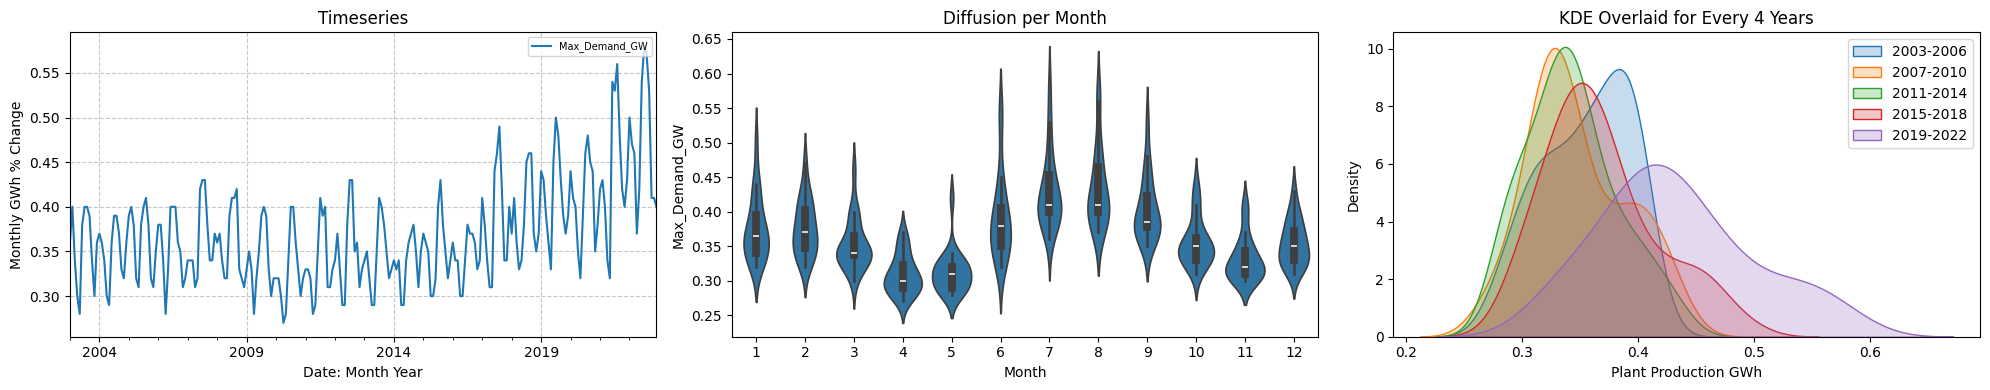

In [3]:
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(20, 4))

# Visually check if Plant_Production_GWh timeseries is healthy, its the most skewed.
all_data_df[ELEC_DMD_COL].plot(kind="line", ax=axes[0])
axes[0].set_xlabel("Date: Month Year")
axes[0].set_ylabel("Monthly GWh % Change")
axes[0].grid(axis="both", linestyle="--", alpha=0.7)
axes[0].set_title("Timeseries")
axes[0].legend(fontsize=7, loc="upper right")

sampling_subset = pd.DataFrame(all_data_df[ELEC_DMD_COL].copy())
sampling_subset["Month"] = sampling_subset.index.month

# Distribution per Month will be used for weights for synthetic data
# for the rest, we observe skewness and outliers.
sns.violinplot(x="Month", y=ELEC_DMD_COL, data=sampling_subset, ax=axes[1])
axes[1].set_title("Diffusion per Month")

axes[2].set_title("KDE Overlaid for Every 4 Years")
axes[2].set_xlabel("Plant Production GWh")
axes[2].set_ylabel("Density")
for start_year in range(all_data_df.index.year.min(), all_data_df.index.year.max(), 4):
    end_year = start_year + 3
    year_data = all_data_df[
        (all_data_df.index.year >= start_year) & (
            all_data_df.index.year <= end_year)
    ]
    sns.kdeplot(
        year_data[ELEC_DMD_COL],
        ax=axes[2],
        fill=True,
        label=f"{start_year}-{end_year}",
    )
axes[2].legend()

plt.tight_layout()
plt.show()

In addition, we want to explore the emissions affect on the demand and other features.

Emissions timeseries had moderate quality, having to be resampled every month and interpolated for fill gaps. Additionally, inputting of monthly emissions was performed by scaling he yearly amount to monthly, weighted by the NSO's provided power output at monthly distribution. 

In [4]:
# the Datasets below need unique data wrangling
C02_DS = "emissions_c02_g.csv"
CO2_COL = "emissions_c02_GG"
GRAMS_TO_GIGA = 1e-9

c02_df = pd.read_csv(os.path.join(RAW_DATA_PATH, C02_DS))

c02_df["Year"] = pd.to_datetime(c02_df["Year"], format="%Y")
c02_df.set_index("Year", drop=True, inplace=True)
c02_df.rename(columns={"Emissions": CO2_COL}, inplace=True)

c02_df = c02_df.groupby("Year")[CO2_COL].sum()
c02_df = (
    c02_df.resample("MS")
    .ffill()
    .to_frame(name=CO2_COL)
    .sort_values(by="Year", ascending=True)
)

# Break yearly into monthly.
extended_index = pd.date_range(
    start=c02_df.index.min(), end="2022-12-01", freq="MS")
c02_df = c02_df.reindex(extended_index)
c02_df["Totals"] = c02_df[CO2_COL]
c02_df[CO2_COL] /= 12
c02_df = c02_df.ffill()
corr = all_data_df[ELEC_DMD_COL].corr(c02_df[CO2_COL])
print(f"Corr coeff: {corr:0.02f}")

# We will interpolate CO2 production using the plants monthly supply as weights.
sampling_subset = pd.DataFrame(all_data_df[ELEC_DMD_COL].copy())
sampling_subset = sampling_subset.resample("MS").ffill()
sampling_subset["total"] = sampling_subset.groupby(sampling_subset.index.year)[
    ELEC_DMD_COL
].transform("sum")
sampling_subset["weights"] = sampling_subset[ELEC_DMD_COL] / \
    sampling_subset["total"]
print(sampling_subset["weights"].head(12))

c02_df[CO2_COL] = round(sampling_subset["weights"] * (c02_df[CO2_COL]), 2)
c02_df = c02_df[(c02_df.index >= START_DATE) & (c02_df.index <= END_DATE)]

all_data_df[CO2_COL] = c02_df[CO2_COL]
all_data_df.head(13)

Corr coeff: 0.38
Date
2003-01-01    0.084706
2003-02-01    0.094118
2003-03-01    0.080000
2003-04-01    0.070588
2003-05-01    0.065882
2003-06-01    0.089412
2003-07-01    0.094118
2003-08-01    0.094118
2003-09-01    0.091765
2003-10-01    0.080000
2003-11-01    0.070588
2003-12-01    0.084706
Freq: MS, Name: weights, dtype: float64


,Max_Demand_GW,Plant_Production_GWh,Imports_GWh,Renewables_Production_GWh,emissions_c02_GG
Date,,,,,
2003-01-01,0.36,182.08,0.0,0.0,47.52
2003-02-01,0.40,187.10,0.0,0.0,52.80
2003-03-01,0.34,176.37,0.0,0.0,44.88
2003-04-01,0.30,156.53,0.0,0.0,39.60
2003-05-01,0.28,163.97,0.0,0.0,36.96
2003-06-01,0.38,193.97,0.0,0.0,50.16
2003-07-01,0.40,232.95,0.0,0.0,52.80
2003-08-01,0.40,227.09,0.0,0.0,52.80
2003-09-01,0.39,188.77,0.0,0.0,51.48


Visualize the quality and outcome of wrangling on this timeseries. CO2 should move with the production timeseries:

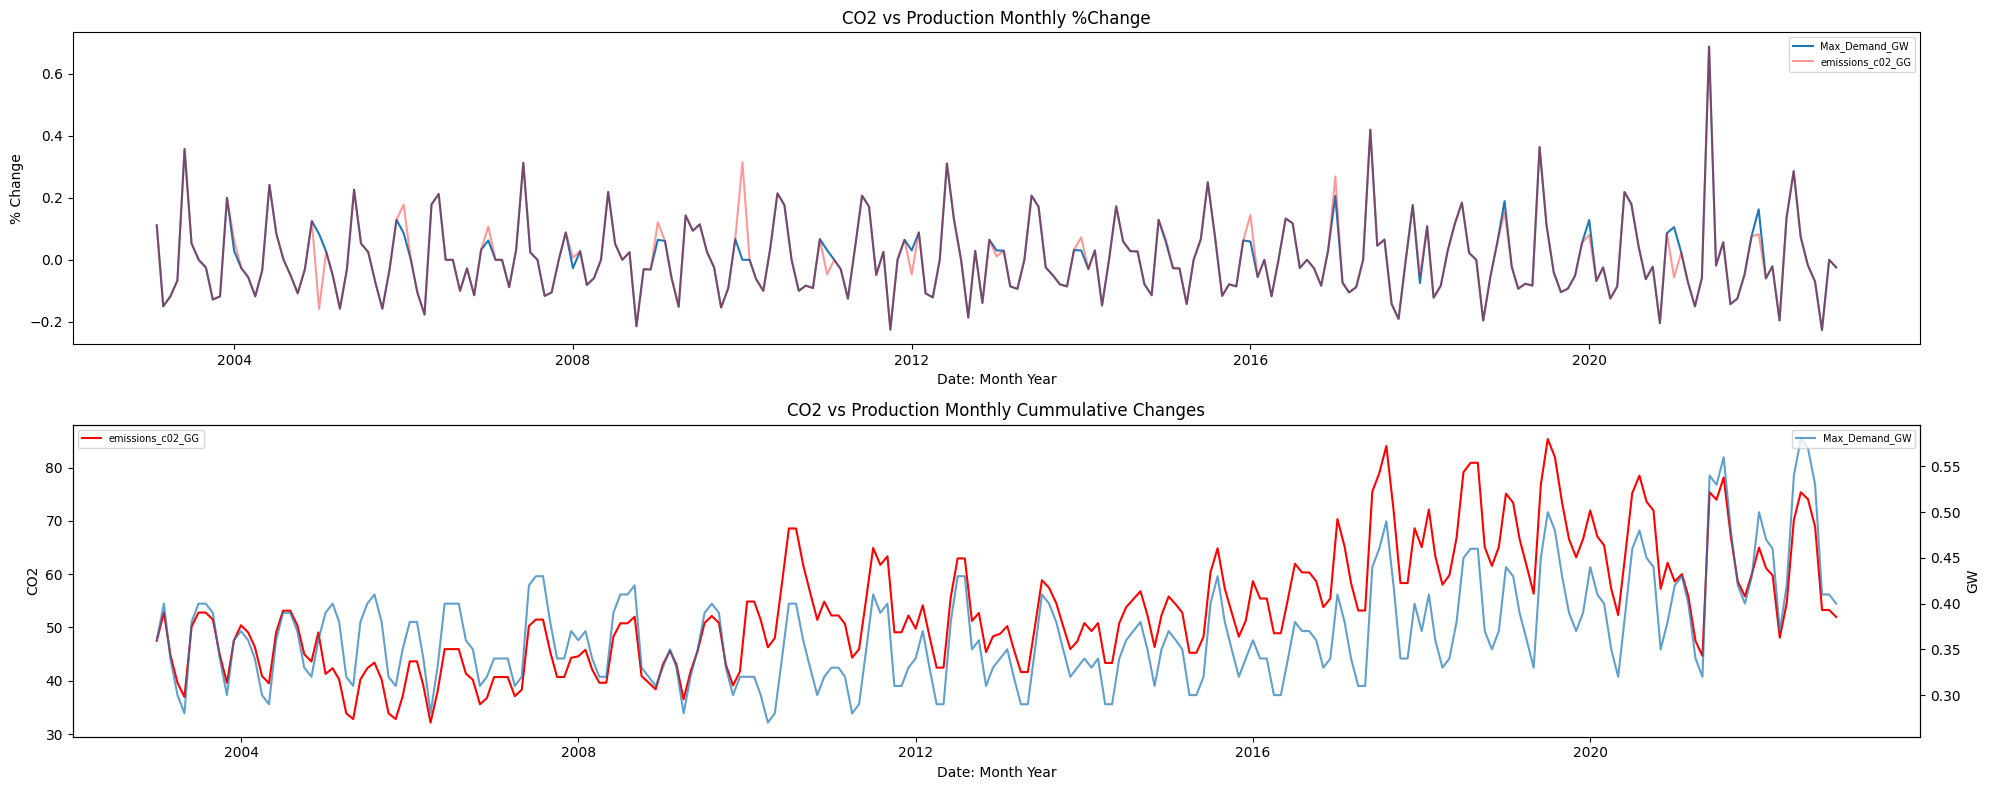

In [5]:
# Visually check timeseries is healthy.
fig, axes = plt.subplots(2, 1, figsize=(20, 8))
axes[0].plot(all_data_df[ELEC_DMD_COL].pct_change(),
             label=ELEC_DMD_COL, alpha=1)
axes[0].plot(all_data_df[CO2_COL].pct_change(),
             label=CO2_COL, alpha=0.4, c="r")
axes[0].set_xlabel("Date: Month Year")
axes[0].set_ylabel("% Change")
axes[0].set_title("CO2 vs Production Monthly %Change")
axes[0].legend(fontsize=7, loc="upper right")


axes[1].plot(all_data_df[CO2_COL], label=CO2_COL, c="r")
axes[1].set_xlabel("Date: Month Year")
axes[1].set_ylabel("CO2")
axes[1].set_title("CO2 vs Production Monthly Cummulative Changes")
axes[1].legend(fontsize=7, loc="upper left")

ax2 = axes[1].twinx()
ax2.plot(all_data_df[ELEC_DMD_COL], label=ELEC_DMD_COL, alpha=0.7)
ax2.set_ylabel("GW")
ax2.legend(fontsize=7, loc="upper right")

plt.tight_layout()
plt.show()

The values suggestion correlation and cointegrated have been achieved **artificially** - with the assumption that high production creates higher emissions. 

In future observations, more granular datasets should be aquired to avoid this oversampling

In [6]:
from statsmodels.tsa.stattools import coint

t_test, p_value, _ = coint(all_data_df[ELEC_DMD_COL], all_data_df[CO2_COL])
print(f"T-stat: {t_test:0.02f}")
print(f"p-value: {p_value:0.02f}")
corr = all_data_df[ELEC_DMD_COL].corr(all_data_df[CO2_COL])
print(f"Corr coeff: {corr:0.02f}")

T-stat: -2.22
p-value: 0.41
Corr coeff: 0.75


## GDP & Industry Indices

Gross domestic product is a monetary measure of the market value of all the final goods and services produced in a specific time period by a country or countries.

Therefore the most logical way to increase granularity would be to distribute it according to the Plant_Production_GWh. In loose terms, this assumes that the more the economy is generating, the more energy is being consumed.

For data assurance, Malta should have ended 2022 with 16 Billion Euros in GDP, reference [here](https://nso.gov.mt/gross-domestic-product-2022/).

C:\Users\adamd\AppData\Local\Temp\ipykernel_4892\2194032879.py:25: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  all_data_df[GDP_COL].pct_change().plot(kind="line", ax=axes[0])


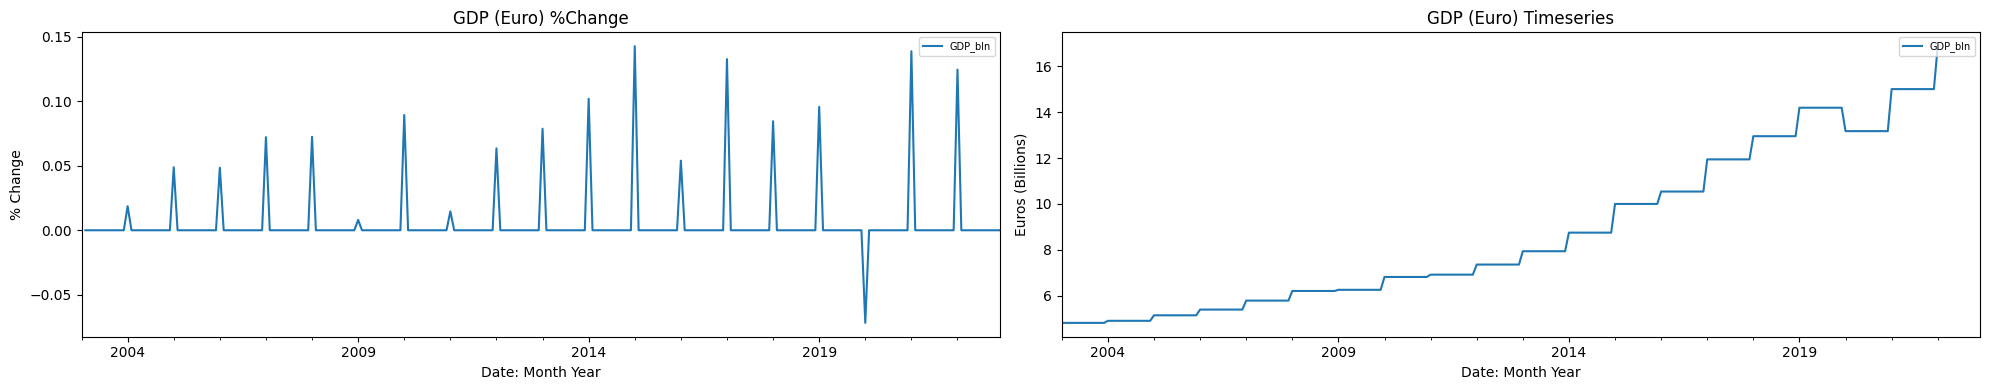

In [7]:
GDP_DS = "gdp_EUR.csv"
GDP_COL = "GDP_bln"


UNIT_TO_BILLIONS = 1000000000

gdp_df = pd.read_csv(f"{RAW_DATA_PATH}/{GDP_DS}")
gdp_df = gdp_df.T
gdp_df.columns = [GDP_COL]


gdp_df[GDP_COL] = gdp_df[GDP_COL].apply(
    lambda x: round(x / UNIT_TO_BILLIONS, 2))

# Indexed on year only, resample to monthly. interpolate everything.
gdp_df.index = pd.to_datetime(gdp_df.index, format="%Y")
gdp_df = gdp_df.resample("MS").ffill()

gdp_df = gdp_df[(gdp_df.index >= START_DATE) & (gdp_df.index <= END_DATE)]

all_data_df[GDP_COL] = round(gdp_df[GDP_COL], 2).interpolate().ffill().bfill()

# Visually check timeseries is healthy.
fig, axes = plt.subplots(1, 2, figsize=(20, 4))
all_data_df[GDP_COL].pct_change().plot(kind="line", ax=axes[0])
axes[0].set_xlabel("Date: Month Year")
axes[0].set_ylabel("% Change")
axes[0].set_title("GDP (Euro) %Change")
axes[0].legend(fontsize=7, loc="upper right")

all_data_df[GDP_COL].plot(kind="line", ax=axes[1])
axes[1].set_xlabel("Date: Month Year")
axes[1].set_ylabel("Euros (Billions)")
axes[1].set_title("GDP (Euro) Timeseries")
axes[1].legend(fontsize=7, loc="upper right")

plt.tight_layout()
plt.show()

# Population

Population is a stock figure at the end of the year, therefore it can be interpolated by distributing the CHANGE in population in a year over the period.

The last year in the data set, 2022, cannot be interpolated therefore the population is assumed constant for the whole year.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


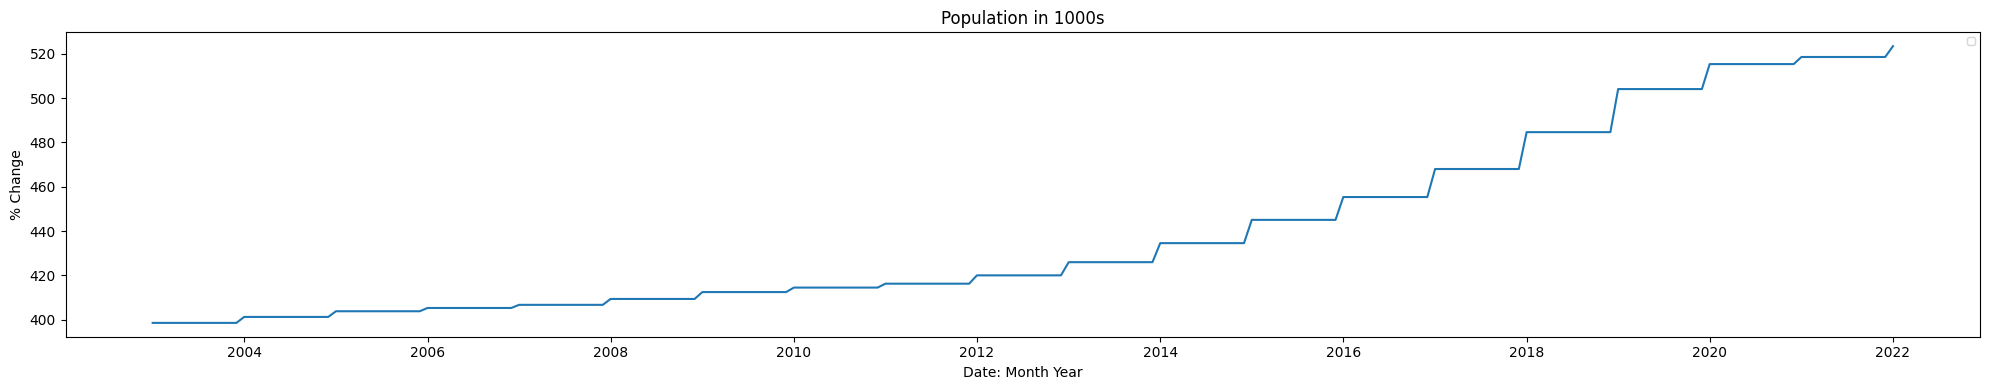

,Max_Demand_GW,Plant_Production_GWh,Imports_GWh,Renewables_Production_GWh,emissions_c02_GG,GDP_bln,Population_k
Date,,,,,,,
2022-10-01,0.41,225.89,66.13,23.85,53.28,NaN,523.42
2022-11-01,0.41,206.40,13.05,16.79,53.28,NaN,523.42
2022-12-01,0.40,207.78,22.02,15.84,51.98,NaN,523.42


In [8]:
POP_DS = "malta_population.csv"
POP_COL = "Population_k"

UNIT_TO_THOUSAND = 1000

pop_df = pd.read_csv(f"{RAW_DATA_PATH}/{POP_DS}")
pop_df = pop_df.T


pop_df.columns = [POP_COL]
pop_df[POP_COL] = pop_df[POP_COL] / UNIT_TO_THOUSAND

# Indexed on year only, resample to monthly. interpolate everything.
pop_df.index = pd.to_datetime(pop_df.index, format="%Y")
pop_df = pop_df.resample("MS").ffill()
pop_df = pop_df[(pop_df.index >= START_DATE) & (pop_df.index <= END_DATE)]

plt.figure(figsize=(20, 4))
plt.plot(pop_df)
plt.xlabel("Date: Month Year")
plt.ylabel("% Change")
plt.title("Population in 1000s")
plt.legend(fontsize=7, loc="upper right")
plt.tight_layout()
plt.show()

# Population is missing the last months from the resample.
all_data_df[POP_COL] = pop_df[POP_COL]
all_data_df[POP_COL] = round(
    all_data_df[POP_COL], 2).interpolate().ffill().bfill()
all_data_df.tail(3)

## Climate

Climate is pulled fromm the meteostat SDK. It's data quality is high:

In [9]:
from meteostat import Point, Monthly

TEMP_MAX_COL = "tmax"

# Create Point for Malta - specify latitude and longitude
malta = Point(35.8992, 14.5141)
temp_data_df = Monthly(malta, START_DATE, END_DATE)
temp_data_df = temp_data_df.fetch()
temp_data_df = temp_data_df[
    (temp_data_df.index >= START_DATE) & (temp_data_df.index <= END_DATE)
]

temp_data_df.index = pd.to_datetime(temp_data_df.index, format="%Y-%m-%d")
temp_data_df = temp_data_df.interpolate().bfill()
temp_data_df.head(3)

,tavg,tmin,tmax,prcp,wspd,pres,tsun
time,,,,,,,
2003-01-01,13.2,10.9,15.6,152.0,12.5,1014.9,9900.0
2003-02-01,10.4,7.9,13.0,150.0,12.5,1016.7,8280.0
2003-03-01,12.7,9.8,15.7,55.0,12.5,1020.6,13920.0


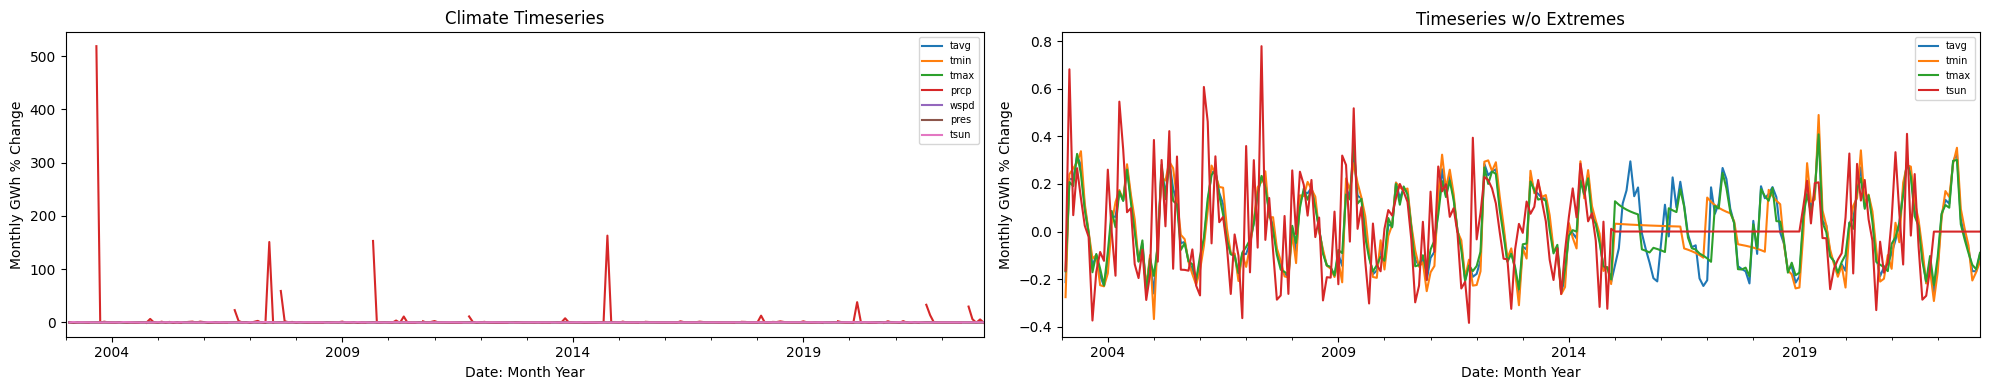

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(20, 4))

# Visually check if climate timeseries is healthy.
temp_data_df.pct_change().ffill().plot(kind="line", ax=axes[0])
axes[0].set_xlabel("Date: Month Year")
axes[0].set_ylabel("Monthly GWh % Change")
axes[0].set_title("Climate Timeseries")
axes[0].legend(fontsize=7, loc="upper right")

temp_data_df.drop(columns=["prcp", "wspd", "pres"], axis=1).pct_change().ffill().plot(
    kind="line", ax=axes[1]
)
axes[1].set_xlabel("Date: Month Year")
axes[1].set_ylabel("Monthly GWh % Change")
axes[1].set_title("Timeseries w/o Extremes")
axes[1].legend(fontsize=7, loc="upper right")

plt.tight_layout()
plt.show()

Values of sun, pressure and wind have poor data quality, and are best dropped.

In [11]:
all_data_df[ELEC_DMD_COL].tail(13)

all_data_df = pd.concat(
    [all_data_df, temp_data_df[["tmin", "tavg", TEMP_MAX_COL]]],
    axis=1,
    ignore_index=False,
)

all_data_df = all_data_df.interpolate().ffill().fillna(0)
all_data_df.tail(3)

,Max_Demand_GW,Plant_Production_GWh,Imports_GWh,Renewables_Production_GWh,emissions_c02_GG,GDP_bln,Population_k,tmin,tavg,tmax
2022-10-01,0.41,225.89,66.13,23.85,53.28,16.87,523.42,18.2,21.6,25.3
2022-11-01,0.41,206.40,13.05,16.79,53.28,16.87,523.42,15.1,18.0,21.3
2022-12-01,0.40,207.78,22.02,15.84,51.98,16.87,523.42,13.2,16.3,19.4


@TODO: if this is still required and the rationale would help

In [12]:
# Interpolating half way points for the data to double the number of data points available and increase granularity
def add_midpoints(df, oversample_cols):
    midpoints_df = pd.DataFrame(index=df.index)

    # Calculate midpoints for "Max_Demand_GW" column
    # shift by 1 upwards so the data is correctly aligned with respect to the GWh data
    midpoints_df["Max_Demand_GW"] = (
        (df["Max_Demand_GW"] + df["Max_Demand_GW"].shift(1)) / 2
    ).shift(-1)

    # Calculate midpoints for other columns with units GWh by dividing the value by 2.
    # Overwrite the original data with the value divided by 2 as well.
    # GWh is a value that is calculated over a whole month; averaging the last and next data point may not be suitable.
    for column in oversample_cols:
        df[column] /= 2
        midpoints_df[column] = df[column]

    # Calculate midpoint dates which is the 15th for simplicity
    midpoints_df.index = midpoints_df.index.to_series().apply(
        lambda d: d.replace(day=15)
    )

    result_df = pd.concat([df, midpoints_df], axis=0)
    result_df.sort_index(inplace=True)

    return result_df


# Sythetic oversampling using mid month.
SYNTH_OVERSAMPLE_COLS = [
    "Max_Demand_GW",
    ELEC_DMD_COL,
    "Imports_GWh",
    "Renewables_Production_GWh",
]

""" This is for oversampling, for models that need more data representation
all_data_orig_df = all_data_df.copy()
all_data_df = (
    add_midpoints(all_data_df, SYNTH_OVERSAMPLE_COLS)
    .drop_duplicates(keep="last")
    .ffill()
)
"""
all_data_df.tail(5)

,Max_Demand_GW,Plant_Production_GWh,Imports_GWh,Renewables_Production_GWh,emissions_c02_GG,GDP_bln,Population_k,tmin,tavg,tmax
2022-08-01,0.57,317.19,84.73,30.34,74.07,16.87,523.42,24.3,27.9,32.3
2022-09-01,0.53,273.01,76.46,25.78,68.87,16.87,523.42,22.9,25.9,29.4
2022-10-01,0.41,225.89,66.13,23.85,53.28,16.87,523.42,18.2,21.6,25.3
2022-11-01,0.41,206.40,13.05,16.79,53.28,16.87,523.42,15.1,18.0,21.3
2022-12-01,0.40,207.78,22.02,15.84,51.98,16.87,523.42,13.2,16.3,19.4


# Visualize the Timeseries

All features are a timeseries, which means there is a patteren across time. 

We assume, upward/downward trends, and spikes or dips according to the month in the year (seasonality). Plotting to verify these assumptions:

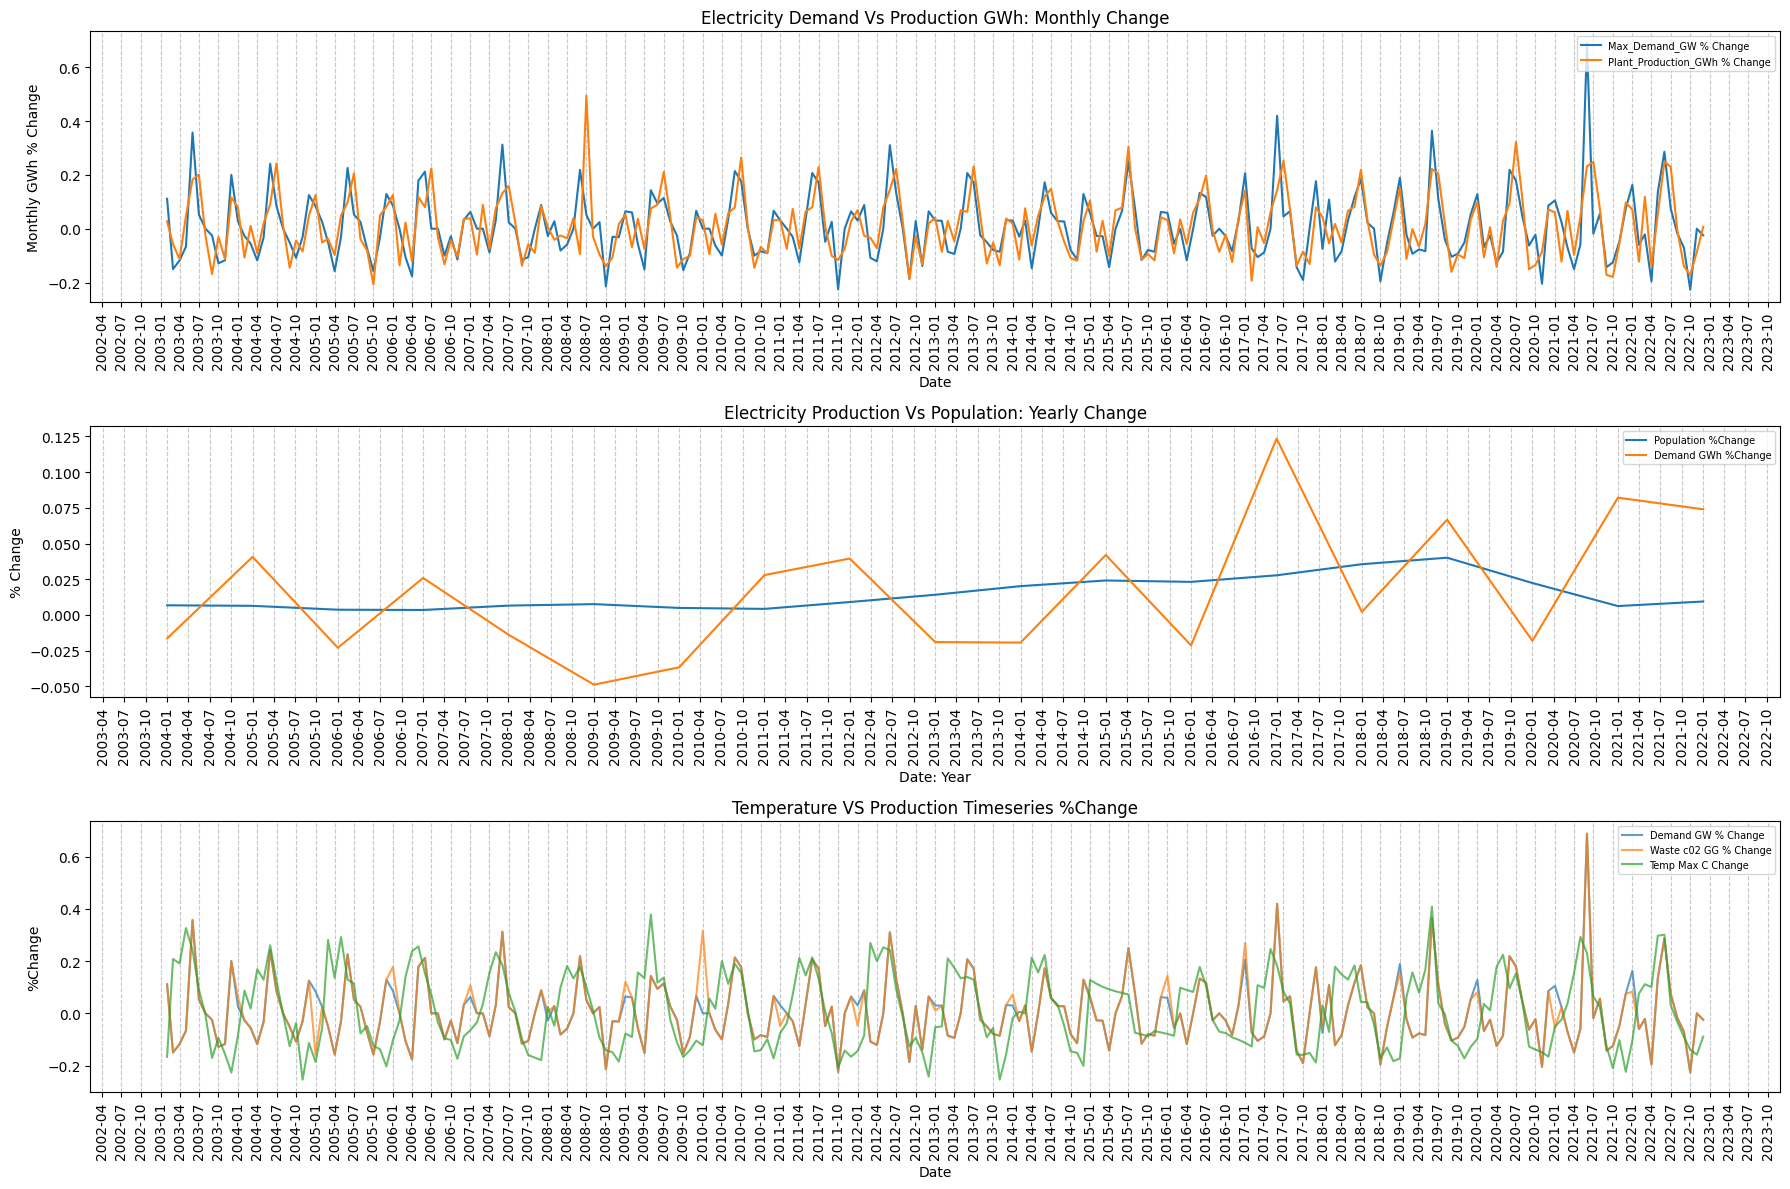

In [13]:
import matplotlib.dates as mdates

fig, axes = plt.subplots(3, 1, figsize=(18, 12))

axes[0].plot(
    all_data_df[[ELEC_DMD_COL, ELEC_PROD_COL]].pct_change().ffill(),
    label=[f"{ELEC_DMD_COL} % Change", f"{ELEC_PROD_COL} % Change"],
)
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Monthly GWh % Change")
axes[0].grid(axis="x", linestyle="--", alpha=0.7)
axes[0].tick_params(axis="x", rotation=90)
axes[0].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
axes[0].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
axes[0].set_title("Electricity Demand Vs Production GWh: Monthly Change")
axes[0].legend(fontsize=7, loc="upper right")

axes[1].plot(
    all_data_df[POP_COL].resample("YS").mean().pct_change().dropna(),
    label="Population %Change",
)
axes[1].plot(
    all_data_df[ELEC_DMD_COL].resample("YS").mean().pct_change().dropna(),
    label="Demand GWh %Change",
)
axes[1].set_xlabel("Date: Year")
axes[1].set_ylabel("% Change")
axes[1].set_title("Electricity Production Vs Population: Yearly Change")
axes[1].grid(axis="x", linestyle="--", alpha=0.7)
axes[1].tick_params(axis="x", rotation=90)
axes[1].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
axes[1].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
axes[1].legend(fontsize=7, loc="upper right")


axes[2].plot(
    all_data_df[ELEC_DMD_COL].pct_change().dropna(),
    label="Demand GW % Change",
    alpha=0.7,
)
axes[2].plot(
    all_data_df[CO2_COL].pct_change().dropna(),
    label="Waste c02 GG % Change",
    alpha=0.7,
)
axes[2].plot(
    all_data_df[TEMP_MAX_COL].pct_change().dropna(),
    label="Temp Max C Change",
    alpha=0.7,
)
axes[2].set_ylabel("%Change")
axes[2].set_xlabel("Date")
axes[2].grid(axis="x", linestyle="--", alpha=0.7)
axes[2].tick_params(axis="x", rotation=90)
axes[2].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
axes[2].xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
axes[2].set_title("Temperature VS Production Timeseries %Change")
axes[2].legend(fontsize=7, loc="upper right")

plt.tight_layout()
plt.show()

## Visualizing other Patterns

Pair plot all data to see its shape and note additional patterns.

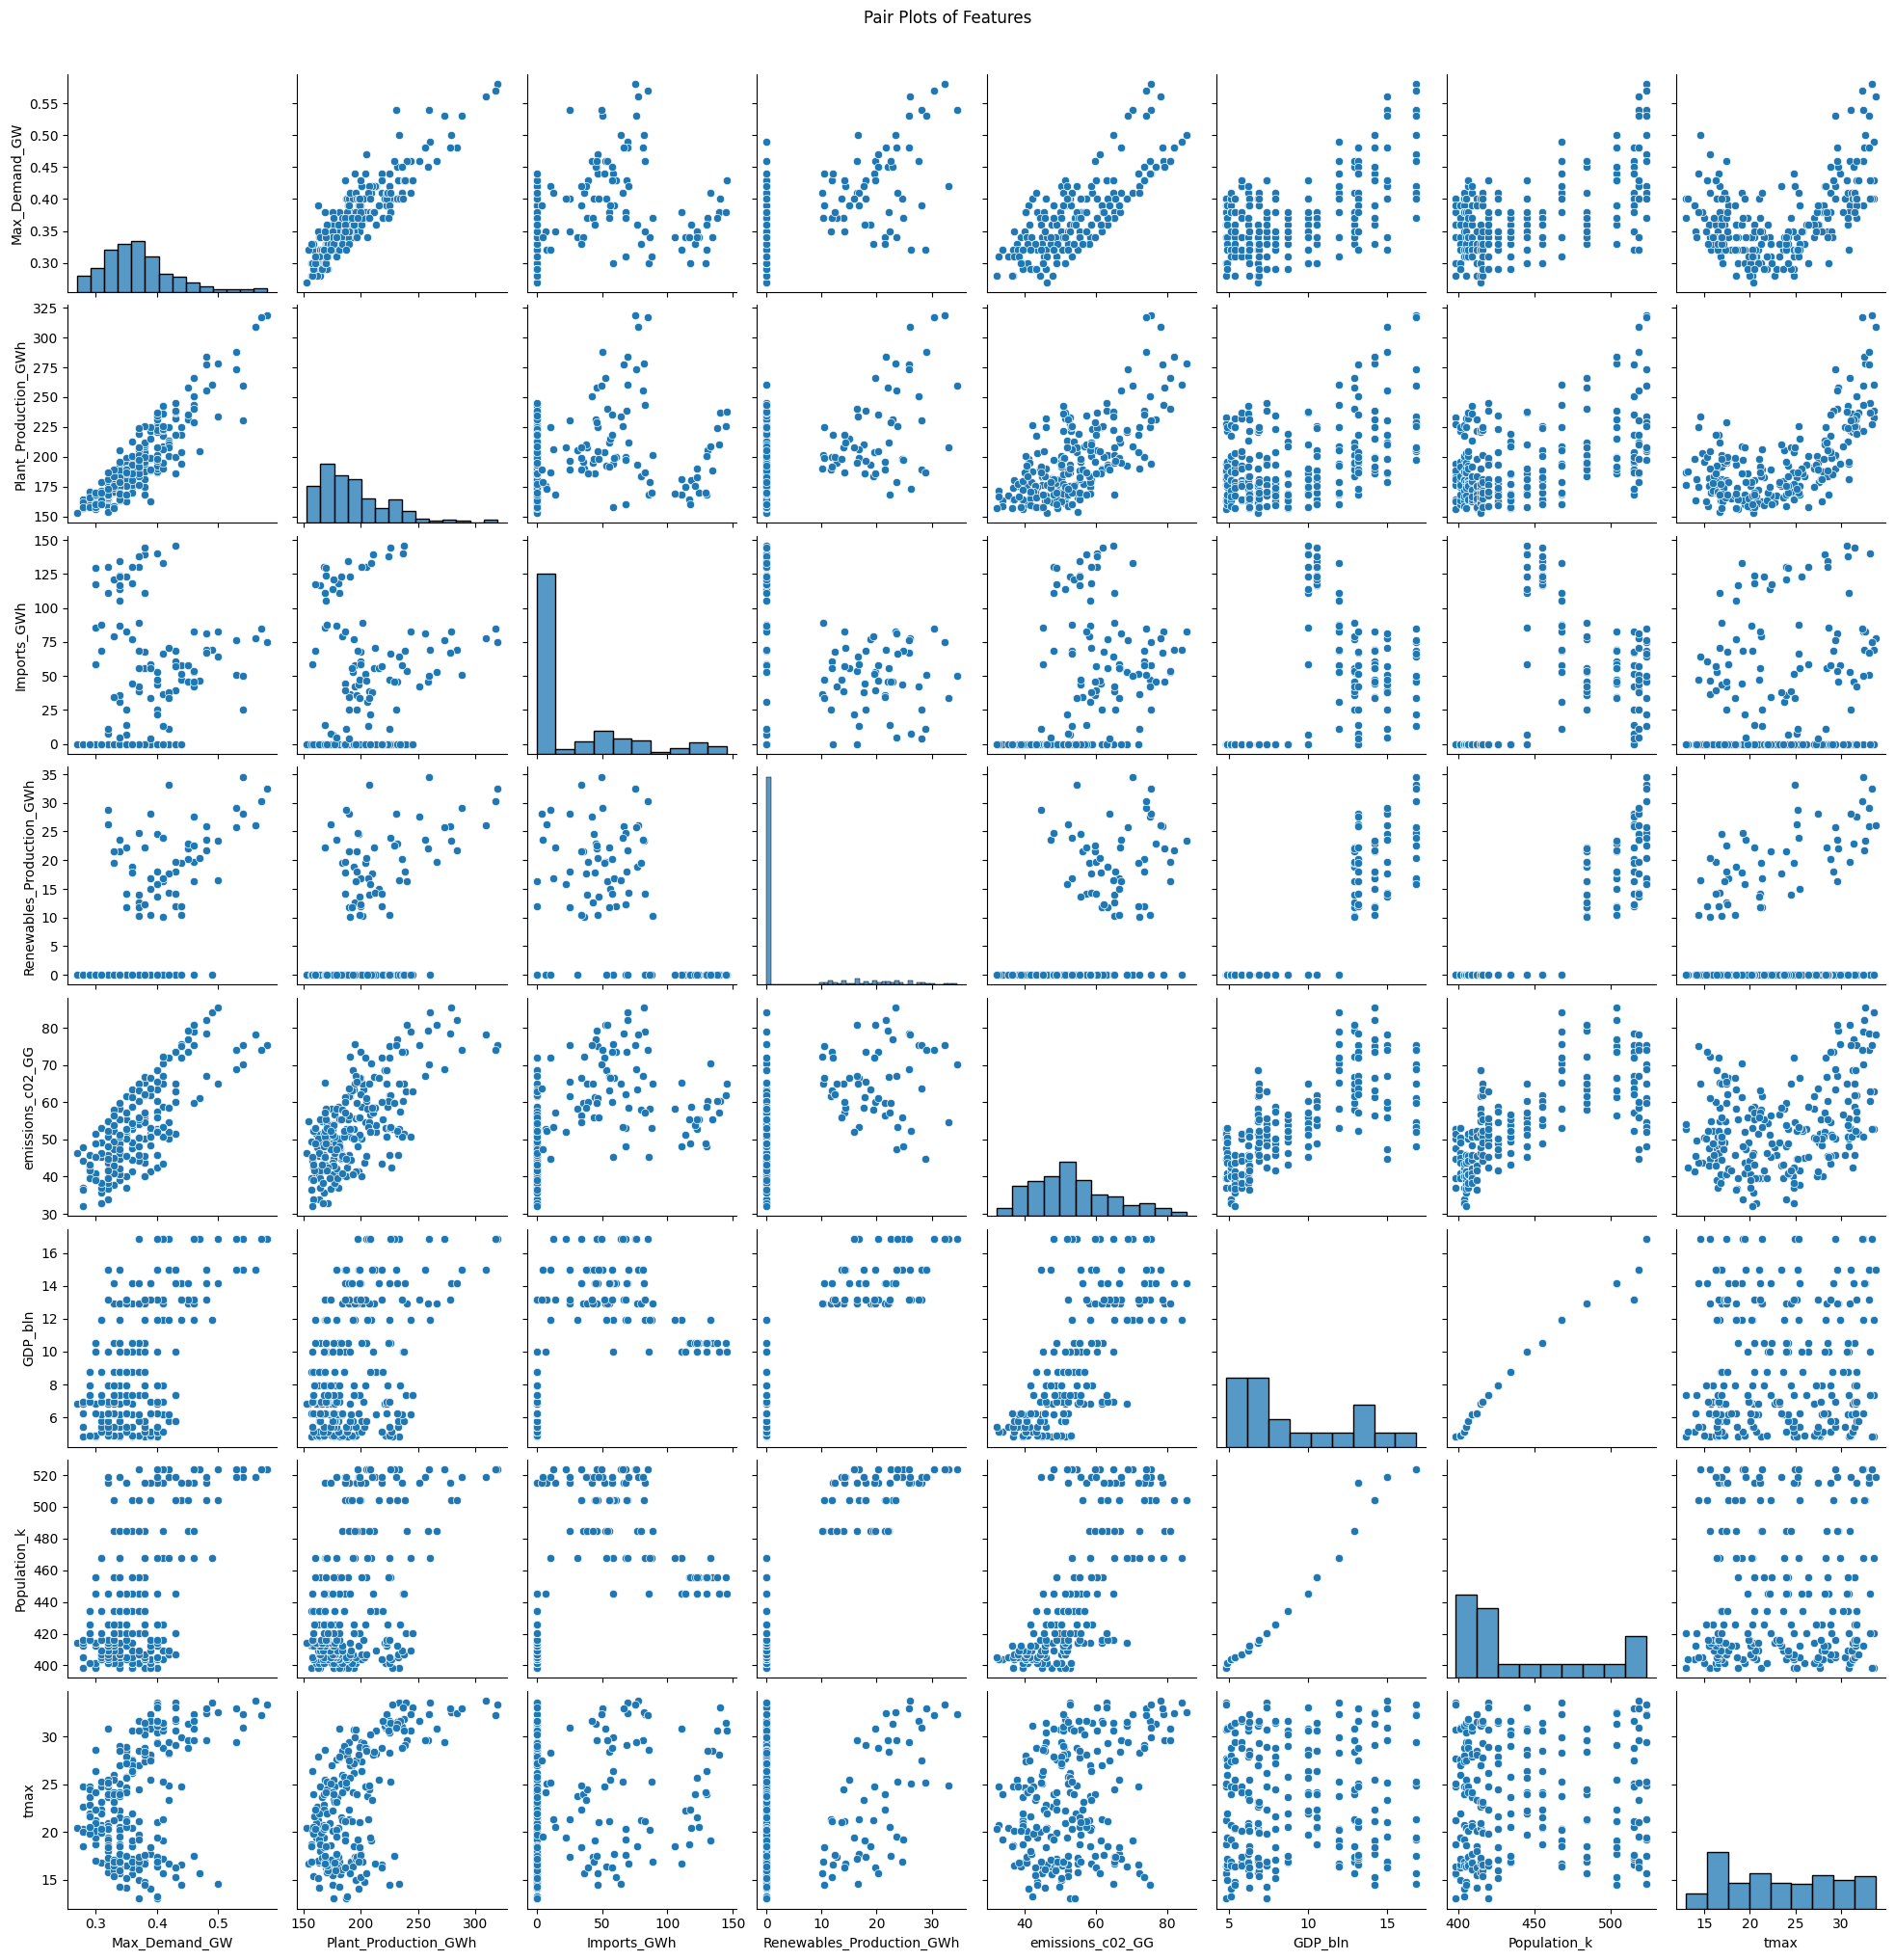

In [14]:
sns.pairplot(all_data_df.drop(columns=["tavg", "tmin", "tavg"]))
plt.suptitle("Pair Plots of Features", y=1.02)
plt.show()

Obversations:
- Demand and Production are similar in patterns and relationships. Production is the output overtime while demand is the highest instantenous output done.
- Imports and renewables have no affect on other data or patterns. These are best dropped.
- GDP index has some relationship with population and polution, and slight patterns with production. 

## Data Relationships' Statistical Tests

Are the moves of statistical significance or arbitary. We will test the correlations, to assure these are not artbiary and we will test for significant cointegration betweent the various features. We have 2 H0s:
1. Features are not correlated, or not in a significant way.
2. Timeseries features are not cointegrated. 

The heatmaps below visualize these:

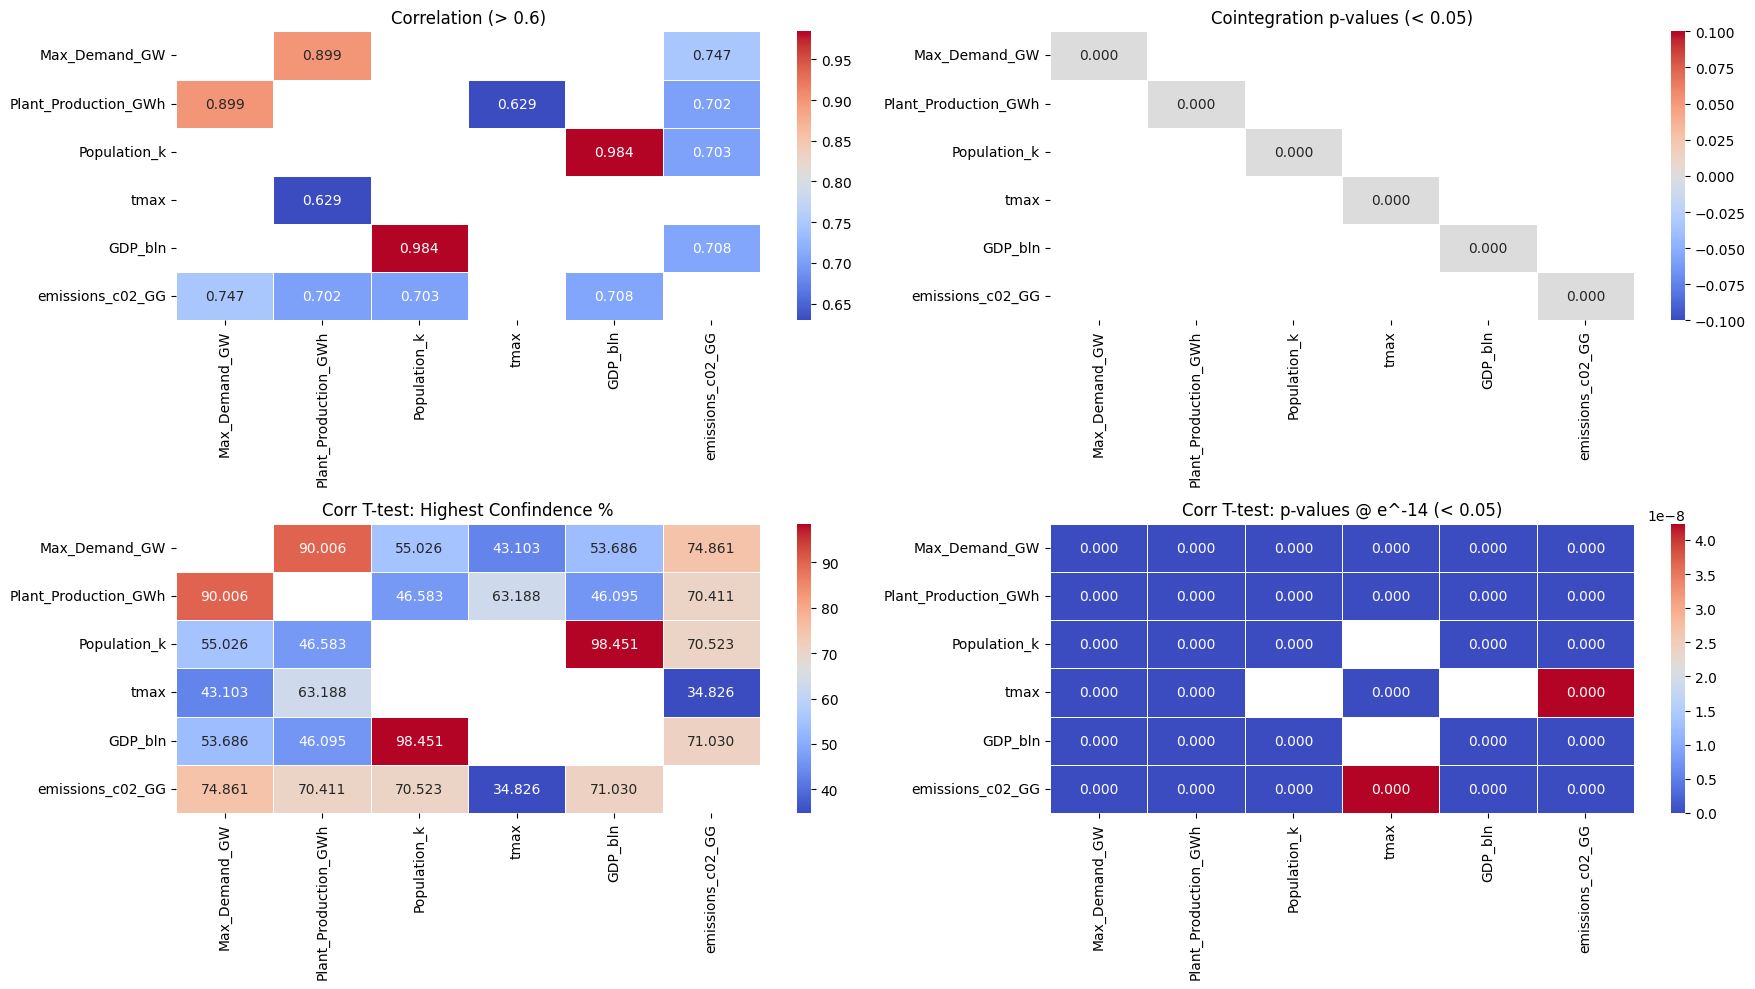

In [15]:
from scipy.stats import pearsonr

CR_THRESHOLD = 0.6
P_THRESHOLD = 0.05

features = [ELEC_DMD_COL, ELEC_PROD_COL,
            POP_COL, TEMP_MAX_COL, GDP_COL, CO2_COL]

corr_matrix = np.zeros((len(features), len(features)))
coint_matrix = np.zeros((len(features), len(features)))
conf_high_matrix = np.zeros((len(features), len(features)))
p_value_matrix = np.zeros((len(features), len(features)))

for i, feature1 in enumerate(features):
    for j, feature2 in enumerate(features):
        if i == j:
            continue
        pr_obj = pearsonr(all_data_df[feature1], all_data_df[feature2])
        corr_matrix[i, j] = pr_obj.statistic
        conf_high_matrix[i, j] = pr_obj.confidence_interval(0.05).high
        p_value_matrix[i, j] = pr_obj.pvalue
        coint_result = coint(all_data_df[feature1], all_data_df[feature2])
        coint_matrix[i, j] = coint_result[1]

corr_df = pd.DataFrame(corr_matrix, index=features, columns=features)
t_value_df = pd.DataFrame(conf_high_matrix, index=features, columns=features)
p_value_df = pd.DataFrame(p_value_matrix, index=features, columns=features)
coint_df = pd.DataFrame(coint_matrix, index=features, columns=features)

plt.figure(figsize=(18, 10))

plt.subplot(2, 2, 1)
sns.heatmap(
    corr_df,
    annot=True,
    cmap="coolwarm",
    fmt=".3f",
    linewidths=0.5,
    mask=(np.abs(corr_matrix) < CR_THRESHOLD),
)
plt.title(f"Correlation (> {CR_THRESHOLD})")

plt.subplot(2, 2, 2)
sns.heatmap(
    coint_df,
    annot=True,
    cmap="coolwarm",
    fmt=".3f",
    linewidths=0.5,
    mask=(coint_df > P_THRESHOLD),
)
plt.title(f"Cointegration p-values (< {P_THRESHOLD})")

plt.subplot(2, 2, 3)
sns.heatmap(
    t_value_df * 100,
    annot=True,
    cmap="coolwarm",
    fmt=".3f",
    linewidths=0.5,
    mask=(t_value_df < 0.1),
)
plt.title(f"Corr T-test: Highest Confindence %")

plt.subplot(2, 2, 4)
# these are so small we should scale visually.
sns.heatmap(
    p_value_df,
    annot=True,
    cmap="coolwarm",
    fmt=".3f",
    linewidths=0.5,
    mask=(p_value_df > P_THRESHOLD),
)
plt.title(f"Corr T-test: p-values @ e^-14 (< {P_THRESHOLD})")

plt.tight_layout()
plt.show()

From the above, the cointegration H0 was not rejected, there is no perceivable cointegration between our timeseries.

The correlation H0 was rejected, with high confidence of its statistical significance for the following:
- Demand and Production, these are almost the same thing. A lagged version would be better if supply of last month could predict the demand of this month.
- Climate extremes and production - the worse the climate, the more the climate control demand.
- Economic index and population - Malta had various economic and industrial upticks leading to immigration.
- CO2 emissions, population, and production - we did artificial inputting here! Plus this is a bidi-product and its relationship needs to be explored. Best to drop for now.

# Output Clean Dataset

Store the train and test sets for models to experiment on.

In [16]:
# this is a time series. No random sampling for splits.
all_data_df.sort_index(inplace=True)
all_data_df.index.name = "Date"

TRAIN_PERC = 0.8
TEST_PERC = 0.2  # No validate for now
train_size = int(len(all_data_df) * TRAIN_PERC)
test_size = int(len(all_data_df) * TEST_PERC)

train_df = all_data_df.iloc[:train_size]
test_df = all_data_df.iloc[train_size: train_size + test_size]

train_df.to_csv("./data/train_data.csv", index=True)
test_df.to_csv("./data/test_data.csv", index=True)